# Join the two datasets

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

In [3]:
df_hourly_weather = pd.read_pickle("datasets\hourly_weather.pkl")
df_accidents = pd.read_pickle("datasets\\accidents.pkl")

In [4]:
df_hourly_weather.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level'],
      dtype='object')

In [5]:
df_accidents.columns

Index(['AccidentUID', 'AccidentType', 'AccidentType_en',
       'AccidentSeverityCategory', 'AccidentSeverityCategory_en',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'RoadType', 'RoadType_en',
       'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N', 'CantonCode',
       'MunicipalityCode', 'AccidentYear', 'AccidentMonth', 'AccidentMonth_en',
       'AccidentWeekDay', 'AccidentWeekDay_en', 'AccidentHour',
       'AccidentHour_text', 'day', 'date'],
      dtype='object')

### I) Preprocessing for joining the dataframes

df_new = df_hourly_weather
df_new['Accidentyesno'] = 0
df_new.head()

for i in df_hourly_weather['date']:
    for k in df_accidents['date']:
        if i == k:
            df_new['Accidentyesno'] = 1
        else:
            df_new['Accidentyesno'] = 0

In [6]:
#drop columns in accidents dataframe that are not necessary
df_accidents = df_accidents.drop(['AccidentUID', 'day', 'AccidentHour_text', 'AccidentWeekDay_en', 'AccidentYear'], axis = 1)
df_accidents = df_accidents.drop(['AccidentType_en', 'AccidentSeverityCategory_en', 'RoadType_en', 'AccidentSeverityCategory_en',
                                 'CantonCode', 'MunicipalityCode', 'AccidentMonth_en'], axis = 1)

,AccidentType,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,AccidentMonth,AccidentWeekDay,AccidentHour,date
0,at0,as4,False,False,False,rt433,2684605,1245194,1,aw406,0.0,2011-01-01 00:30:00
1,at0,as3,False,True,False,rt433,2682382,1246980,1,aw406,1.0,2011-01-01 01:30:00
2,at0,as4,False,False,False,rt439,2682791,1247749,1,aw406,2.0,2011-01-01 02:30:00
3,at5,as3,False,False,False,rt433,2681199,1247102,1,aw406,2.0,2011-01-01 02:30:00
4,at0,as4,False,False,False,rt433,2682479,1250690,1,aw406,3.0,2011-01-01 03:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
42725,at0,as4,False,True,True,rt433,2683523,1247624,12,aw402,12.0,2019-12-31 12:30:00
42726,at5,as3,False,True,False,rt433,2681573,1247700,12,aw402,18.0,2019-12-31 18:30:00
42727,at1,as4,False,False,False,rt432,2682276,1247052,12,aw402,18.0,2019-12-31 18:30:00
42728,at7,as4,False,False,False,rt433,2683004,1247184,12,aw402,19.0,2019-12-31 19:30:00


#### One Hot Encoding of categorical cols and normalization:

Notes: 
<br>
$a)$ One Hot Encoding for vars of type object
<br>
$b)$ AccidentLocation should be normalized because too many different categories

In [7]:
df_accidents.head(5)

,AccidentType,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,AccidentMonth,AccidentWeekDay,AccidentHour,date
0,at0,as4,False,False,False,rt433,2684605,1245194,1,aw406,0.0,2011-01-01 00:30:00
1,at0,as3,False,True,False,rt433,2682382,1246980,1,aw406,1.0,2011-01-01 01:30:00
2,at0,as4,False,False,False,rt439,2682791,1247749,1,aw406,2.0,2011-01-01 02:30:00
3,at5,as3,False,False,False,rt433,2681199,1247102,1,aw406,2.0,2011-01-01 02:30:00
4,at0,as4,False,False,False,rt433,2682479,1250690,1,aw406,3.0,2011-01-01 03:30:00


In [8]:
#Convert boolean cols to boolean values:
df_accidents['AccidentInvolvingPedestrian'] = 1*df_accidents['AccidentInvolvingPedestrian'].values
df_accidents['AccidentInvolvingBicycle'] = 1*df_accidents['AccidentInvolvingBicycle'].values
df_accidents['AccidentInvolvingMotorcycle'] = 1*df_accidents['AccidentInvolvingMotorcycle'].values

,AccidentType,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,AccidentMonth,AccidentWeekDay,AccidentHour,date
0,at0,as4,0,0,0,rt433,2684605,1245194,1,aw406,0.0,2011-01-01 00:30:00
1,at0,as3,0,1,0,rt433,2682382,1246980,1,aw406,1.0,2011-01-01 01:30:00
2,at0,as4,0,0,0,rt439,2682791,1247749,1,aw406,2.0,2011-01-01 02:30:00
3,at5,as3,0,0,0,rt433,2681199,1247102,1,aw406,2.0,2011-01-01 02:30:00
4,at0,as4,0,0,0,rt433,2682479,1250690,1,aw406,3.0,2011-01-01 03:30:00


In [9]:
#one hot encoding for cols that need to be transformed
categorical_cols = list(df_accidents.select_dtypes(include=['object']).columns)
categorical_cols.extend(['AccidentMonth', 'AccidentHour'])
df_accidents = pd.get_dummies(df_accidents, columns = categorical_cols, drop_first= True, dtype= bool)
df_accidents.columns

Index(['AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'date', 'AccidentType_at00',
       'AccidentType_at1', 'AccidentType_at2', 'AccidentType_at3',
       'AccidentType_at4', 'AccidentType_at5', 'AccidentType_at6',
       'AccidentType_at7', 'AccidentType_at8', 'AccidentType_at9',
       'AccidentSeverityCategory_as2', 'AccidentSeverityCategory_as3',
       'AccidentSeverityCategory_as4', 'RoadType_rt431', 'RoadType_rt432',
       'RoadType_rt433', 'RoadType_rt434', 'RoadType_rt439',
       'AccidentWeekDay_aw402', 'AccidentWeekDay_aw403',
       'AccidentWeekDay_aw404', 'AccidentWeekDay_aw405',
       'AccidentWeekDay_aw406', 'AccidentWeekDay_aw407', 'AccidentMonth_2',
       'AccidentMonth_3', 'AccidentMonth_4', 'AccidentMonth_5',
       'AccidentMonth_6', 'AccidentMonth_7', 'AccidentMonth_8',
       'AccidentMonth_9', 'AccidentMonth_10', 'AccidentMonth_11',
       'Ac

In [16]:
df_accidents.head()

,date,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,AccidentType_at00,AccidentType_at1,AccidentType_at2,AccidentType_at3,...,AccidentHour_14.0,AccidentHour_15.0,AccidentHour_16.0,AccidentHour_17.0,AccidentHour_18.0,AccidentHour_19.0,AccidentHour_20.0,AccidentHour_21.0,AccidentHour_22.0,AccidentHour_23.0
0,2011-01-01 00:30:00,0,0,0,2684605,1245194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:30:00,0,1,0,2682382,1246980,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:30:00,0,0,0,2682791,1247749,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 02:30:00,0,0,0,2681199,1247102,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 03:30:00,0,0,0,2682479,1250690,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert boolean cols to boolean integers:

In [13]:
bool_cols = list(df_accidents.select_dtypes(include=['bool']).columns)
for i in bool_cols:
    df_accidents[i] = 1*df_accidents[i]

Note: 
<br>
Since there are too many different locations in 'AccidentLocation_CHLV95_E' and 'AccidentLocation_CHLV95_N', it would be inappropriate to one hot encode these... So instead we will normalize them.
<br>
We will nevertheless check the distribution of accidents across locations because it might offer some insight regarding locations that are more dangerous...

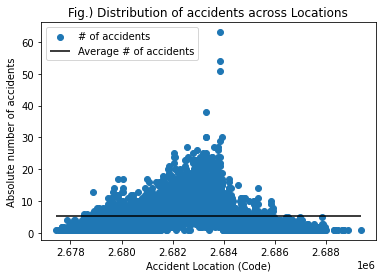

In [57]:
import matplotlib.pyplot as plt
location_dict = df_accidents['AccidentLocation_CHLV95_E'].value_counts().to_dict()
plt.title('Fig.) Distribution of accidents across Locations')
plt.scatter(location_dict.keys(), location_dict.values(), label = '# of accidents')
plt.ylabel('Absolute number of accidents')
plt.xlabel('Accident Location (Code)')
plt.hlines(np.mean(list(location_dict.values())), min(list(location_dict.keys())), 
           max(list(location_dict.keys())), color = 'black', label = 'Average # of accidents')
plt.legend(loc = 'best')

In [66]:
#normalize values of accident locations
from sklearn import preprocessing
column_E, column_N = np.array(df_accidents.pop('AccidentLocation_CHLV95_E')), np.array(df_accidents.pop('AccidentLocation_CHLV95_N'))
normalized_E, normalized_N = preprocessing.normalize([column_E]), preprocessing.normalize([column_N])
df_accidents.insert(6, 'AccidentLocation_CHLV95_E', normalized_E.reshape(-1,1))
df_accidents.insert(7, 'AccidentLocation_CHLV95_N', normalized_N.reshape(-1,1))

In [61]:
#move date column in accidents df to first position
first_column = df_accidents.pop('date')
df_accidents.insert(0, 'date', first_column)

In [62]:
print(df_accidents.shape, df_hourly_weather.shape)

(42730, 64) (78707, 14)


### II) Merge the two datasets

In [64]:
df_join = pd.merge(df_hourly_weather, df_accidents, on='date', how='left')
df_join.shape

(92081, 77)

In [65]:
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentType_at00', 'AccidentType_at1',
       'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N',
       'AccidentType_at2', 'AccidentType_at3', 'AccidentType_at4',
       'AccidentType_at5', 'AccidentType_at6', 'AccidentType_at7',
       'AccidentType_at8', 'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'RoadType_rt431', 'RoadType_rt432', 'RoadType_rt433', 'RoadType_rt434',
       'RoadType_rt439', 'AccidentWeekDay_aw402', 'AccidentWeekDay_aw403',
       'AccidentWeekDay_aw404', 'AccidentWeekDay_aw405',
       'Accid

In [ ]:
df_join.to_csv('datasets\\dataset.csv')